In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Q1

In [46]:
def resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,t0,dt,N):
    "Cette fonctipn permet de resoudre le système (1)"
    temps = np.arange(0,N)*dt+t0 # si j'ai bien compris la question (dt=10/(N-1) pour 10 années)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
        z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))

    return temps,y,z

In [47]:
def h(y,z,alpha,beta,delta,gamma) :

    return y*(alpha-beta*z),z*(delta*y-gamma)

In [48]:
def resolutionSystem1EulerRK4(alpha,beta,delta,gamma,y0,z0,t0,dt,N):
    "Cette fonctipn permet de resoudre le système (1)"
    temps = np.arange(0,N)*dt+t0 # si j'ai bien compris la question (dt=10/(N-1) pour 10 années)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        k1 = h(y[i],z[i],alpha,beta,delta,gamma)
        k2 = h(y[i]+0.5*dt*k1[0],z[i]+0.5*dt*k1[1],alpha,beta,delta,gamma)
        k3 = h(y[i]+0.5*dt*k2[0],z[i]+0.5*dt*k2[1],alpha,beta,delta,gamma)
        k4 = h(y[i]+dt*k3[0],z[i]+dt*k3[1],alpha,beta,delta,gamma)
        y.append(y[i]+(dt/6)*(k1[0]+2*k2[0]+2*k3[0]+k4[0]))
        z.append(z[i]+(dt/6)*(k1[1]+2*k2[1]+2*k3[1]+k4[1]))

    return temps,y,z

# Q2

In [62]:
Nsamples = 1000
alpha = np.random.lognormal(0.5,0.2,Nsamples)
beta = np.random.lognormal(0.05,0.02,Nsamples)
delta = np.random.lognormal(0.05,0.02,Nsamples)
gamma = np.random.lognormal(0.5,0.2,Nsamples)
y0 = np.random.lognormal(1,1,Nsamples)
z0 = np.random.lognormal(1,1,Nsamples)

In [63]:
N = 10001
dt = 20/(N-1) # pour trouver l'indice de l'année k=année/dt
t0 = 1900
solution = resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,t0,dt,N)

In [51]:
# def MC(samples):

#     mean = np.mean(samples) 
#     sigma2 = np.mean(samples**2)-mean**2
#     return mean, sigma2

### t0=1900

In [64]:
bins = [x+ 0.5 for x in range(-1, 30)]

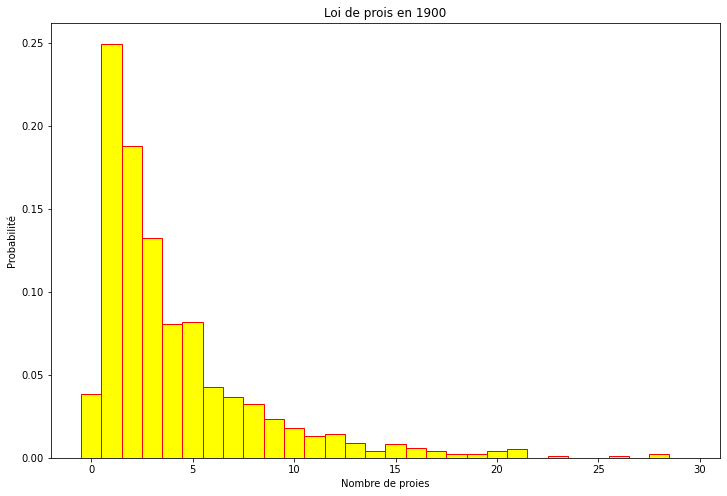

In [65]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(y0),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1900')
plt.show()

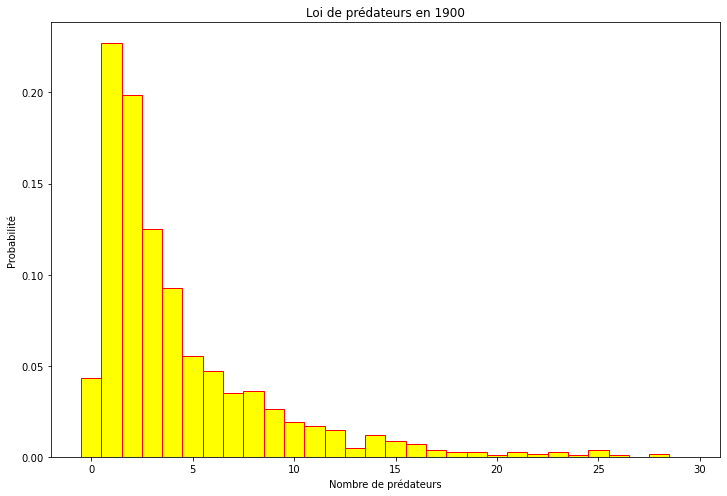

In [54]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(z0),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1900')
plt.show()

### t1=1901

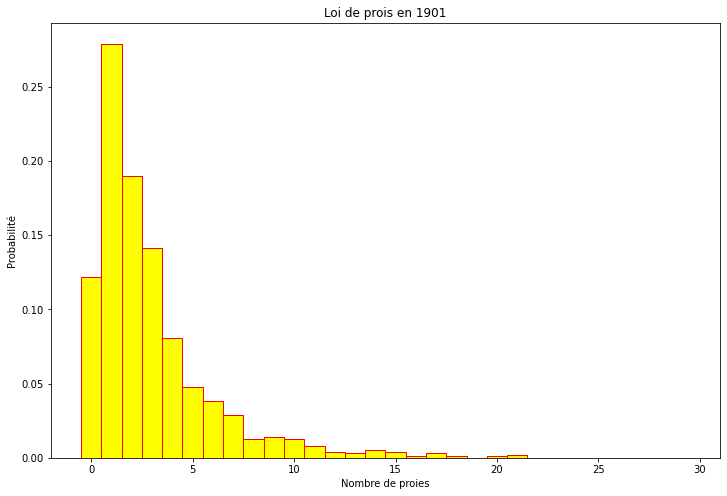

In [55]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[1][50]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1901')
plt.show()

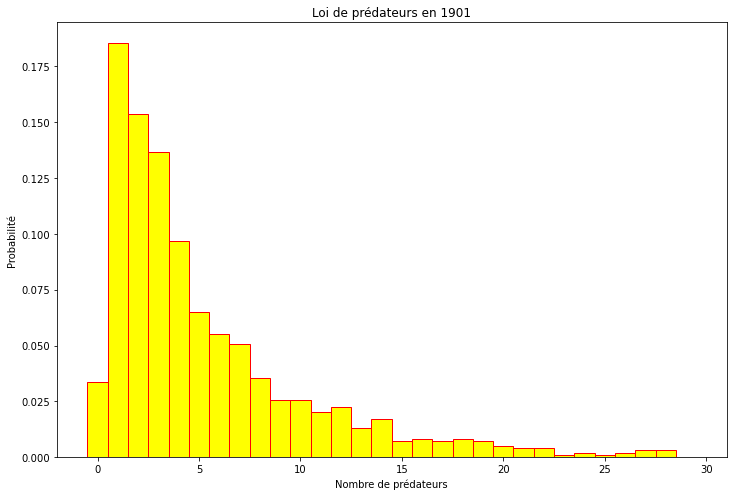

In [56]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[2][50]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1901')
plt.show()

### t2=1920

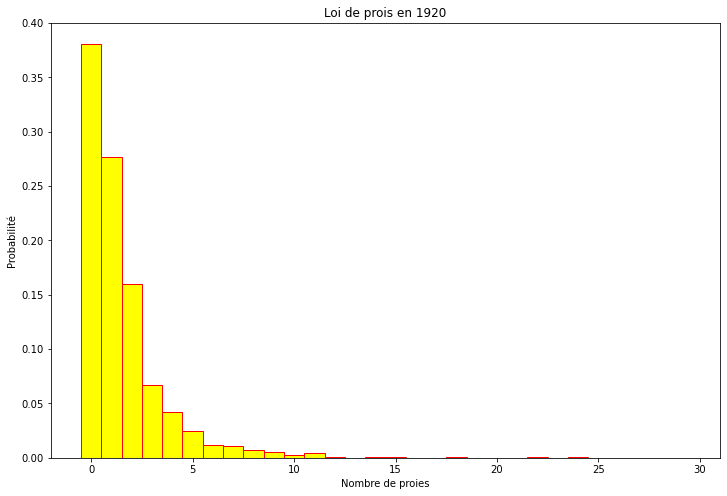

In [57]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[1][-1]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1920')
plt.show()

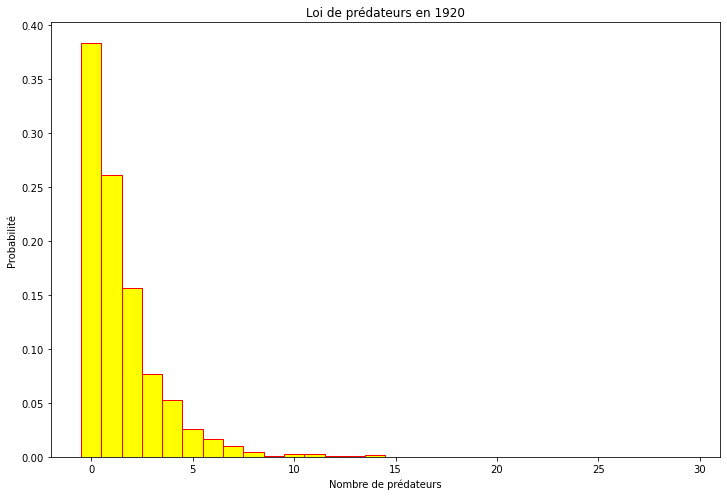

In [58]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[2][-1]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1920')
plt.show()

### la solution moyenne de l'ED I=E(f(X)) ???

In [59]:
yto20 = [np.mean(l) for l in solution[1]]

In [60]:
zto20 = [np.mean(l) for l in solution[2]]

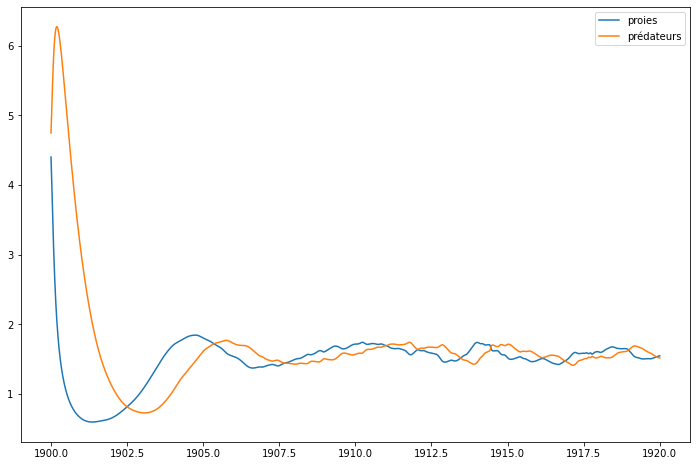

In [61]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(solution[0],yto20, label ="proies")
plt.plot(solution[0],zto20, label ="prédateurs")
# plt.xlabel('Nombre de prédateurs')
# plt.ylabel('Probabilité')
# plt.title('Loi de prédateurs en 1920')
plt.legend()
plt.show()

## Q3

In [67]:
annee = [1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,1920]
lievre = [30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]
lynx = [4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]

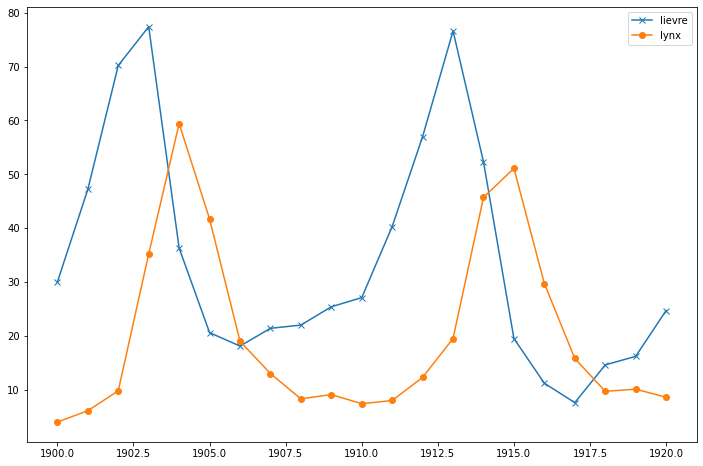

In [76]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(annee,lievre,"-x", label ="lievre")
plt.plot(annee,lynx, "-o",label ="lynx")
plt.legend()
plt.show()

# 4.1 Calibration déterministe

## Q4